In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches

In [3]:
data = pd.read_csv('/Users/gtorres/Desktop/proyecto/00_TrabajoGradoGerman/Codes/kMC ordenado/data.csv')
data = data.drop(['Unnamed: 10'], axis=1)
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data['Fuente(experimento)'] = data.index.astype(str) + '_' + data['Fuente'] + ' (' + data['Experimento'] + ')'
data = data.drop(['Fuente','Experimento'], axis=1)
data.insert(0, 'T0', 0)
data

,T0,T1,T2,T3,T4,T5,T6,T7,T8,Fuente(experimento)
0,0,7.356582,12.689700,16.639759,18.501776,20.487569,23.818749,27.994834,30.050587,0_Adsorcion de As+5 Espana ( 60ppmSb-As)
1,0,20.779935,25.251636,27.748749,29.965348,32.368957,36.389638,43.149442,48.682691,1_Adsorcion de As+5 Espana ( 60ppmAs-As)
2,0,17.067494,22.581181,27.208246,29.441427,31.863017,35.913776,42.724149,48.187964,2_Adsorcion de As+5 Espana ( 90ppmAs-As)
3,0,1.145313,1.696100,2.264219,3.106472,3.699600,4.016499,4.056284,4.106165,3_Adsorcion de Pb Espana (? -FeOOH 0.05 M-Pb)
4,0,6.008902,10.187933,12.134026,13.930267,15.141939,16.922354,20.326410,23.376360,4_Adsorcion de Sb Espana (? -FeOOH 0.05 M-Sb)
5,0,27.241766,41.585839,46.084479,48.311079,49.992389,52.567519,55.551390,57.868871,5_Adsorcion de Sb Espana ( 60ppmSb-Sb)
6,0,34.587323,41.906065,44.300046,46.055632,46.967624,48.723210,51.983584,54.331965,6_Adsorcion de Sb Espana ( 60ppmAs-Sb)
7,0,29.154068,36.910247,42.092633,43.724502,44.948404,50.227982,62.491001,64.050876,7_Adsorcion de Sb Espana ( 60ppmHg-Sb)
8,0,21.817095,29.432051,34.577737,37.286592,39.562941,43.523788,51.331664,56.111996,8_Adsorcion de Sb Espana ( 120ppmAs-Sb)
9,0,12.184766,16.710792,20.125645,22.100067,23.401391,26.923940,33.789545,37.715952,9_Adsorcion de Sb Espana ( 120ppmSb-Sb)


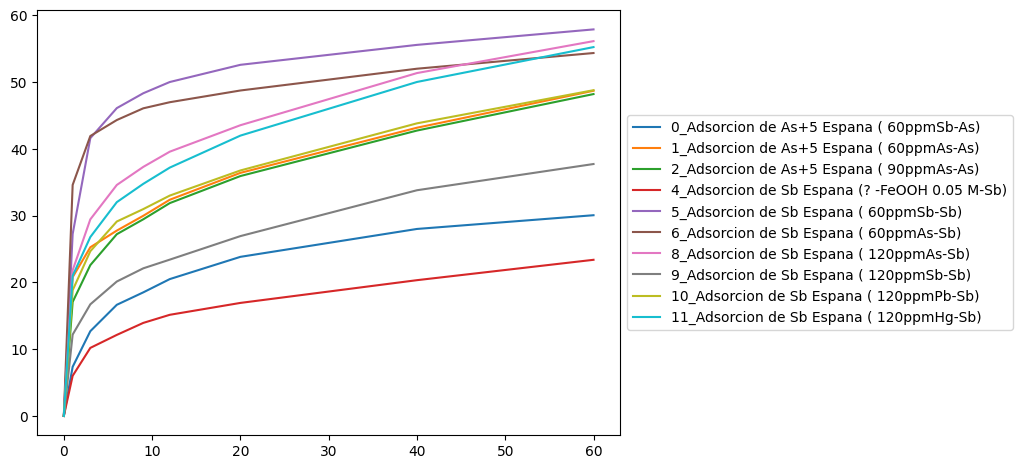

In [4]:
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

for i in range(len(data)):
    if i != 3 and i != 7:
        valores_numericos = pd.to_numeric(data.iloc[i], errors='coerce').dropna()
        etiqueta = data.iloc[i]['Fuente(experimento)']
        plt.plot(time_array, valores_numericos.values, label=etiqueta)

plt.legend()
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        

In [5]:
class LatticeBase(abc.ABC):
    def __init__(self, size):
        self.size = size
        self.lattice = None

    @abc.abstractmethod
    def initialize(self):
        pass

    @abc.abstractmethod
    def get_random_site(self):
        pass

    @abc.abstractmethod
    def get_neighbors(self, site):
        pass

    @abc.abstractmethod
    def get_occupancy(self):
        pass

    @abc.abstractmethod
    def plot(self, title="Estado de la red", figsize=(6,6)):
        pass


In [6]:
class SquareLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site
        return [(ni, nj) for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
                if 0 <= ni < self.size and 0 <= nj < self.size]

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red cuadrada", figsize=(6,6)):
        fig, ax = plt.subplots(figsize=figsize)
        for i in range(self.size):
            for j in range(self.size):
                color = "black" if self.lattice[i, j] == 1 else "white"
                rect = patches.Rectangle((j, self.size - i - 1), 1, 1, edgecolor='gray', facecolor=color)
                ax.add_patch(rect)
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_title(title)
        ax.axis('off')
        plt.show()


In [7]:
import matplotlib.patches as patches
import numpy as np

class HexagonalLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site

        # Definición de vecinos para layout even-r (fila par desplazada)
        if i % 2 == 0:  # Fila par
            deltas = [(-1, 0), (-1, -1),
                    (0, -1),  (0, +1),
                    (+1, 0), (+1, -1)]
        else:  # Fila impar
            deltas = [(-1, +1), (-1, 0),
                    (0, -1),  (0, +1),
                    (+1, +1), (+1, 0)]

        neighbors = [(i + di, j + dj) for di, dj in deltas
                    if 0 <= i + di < self.size and 0 <= j + dj < self.size]

        return neighbors

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red hexagonal", figsize=(6, 6)):
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        fig, ax = plt.subplots(figsize=figsize)

        dx = 3 ** 0.5  # horizontal spacing
        dy = 1.5       # vertical spacing
        radius = 0.5

        for i in range(self.size):
            for j in range(self.size):
                x = dx * j + (dx / 2 if i % 2 else 0)
                y = dy * i
                color = "black" if self.lattice[i, j] == 1 else "white"

                hexagon = patches.RegularPolygon(
                    (x, y),
                    numVertices=6,
                    radius=radius,
                    orientation=np.radians(30),
                    edgecolor='gray',
                    facecolor=color,
                    linewidth=0.5
                )
                ax.add_patch(hexagon)

        ax.set_aspect('equal')
        ax.set_xlim(-1, dx * self.size + 1)
        ax.set_ylim(-1, dy * self.size + 1)
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()
        plt.show()




In [8]:
class KineticMonteCarlo:
    def __init__(self, lattice, T, processes, time_array, time_factor=1e-7):
        self.lattice = lattice
        self.T = T
        self.processes = processes
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time_array = time_array
        self.time = time_array[0]

        self.occupancy = {t: None for t in time_array}
        self.events_count = {p: 0 for p in processes}
        self.events_history = {p: [] for p in processes}
        self.times, self.energies = [], []

        self.lattice.initialize()

    # =======================
    #   Transiciones y tasas
    # =======================

    def pick_random_site(self):
        return self.lattice.get_random_site()

    def count_occupied_neighbors(self, site):
        return sum(self.lattice.lattice[n] for n in self.lattice.get_neighbors(site))

    def calculate_transition_rates(self, site):
        n_ij = self.count_occupied_neighbors(site)
        rates = {}

        if "adsorption" in self.processes:
            p = self.processes["adsorption"]
            E_ads = p["e_ads"] + p.get("e_int_abs", 0) * n_ij
            rates["adsorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))

        if "desorption" in self.processes:
            p = self.processes["desorption"]
            E_des = p["e_des"] + p.get("e_int_des", 0) * n_ij
            rates["desorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))

        if "diffusion" in self.processes:
            e_diff = self.processes["diffusion"]["e_diff"]
            rates["diffusion"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-e_diff / (self.k_b * self.T))

        return rates

    def select_event(self, rates):
        total = sum(rates.values())
        r = np.random.rand() * total
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None

    # ===================
    #     Energía
    # ===================

    def calculate_total_energy(self):
        total_energy = 0
        for i in range(self.lattice.size):
            for j in range(self.lattice.size):
                if self.lattice.lattice[i, j] == 1:
                    n_ij = self.count_occupied_neighbors((i, j))
                    e_ads = self.processes["adsorption"]["e_ads"]
                    e_int_abs = self.processes["adsorption"].get("e_int_abs", 0)
                    total_energy += e_ads + e_int_abs * n_ij
        return total_energy

    # ===================
    #     Simulación
    # ===================

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            self._capture_time_snapshot()

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            

            if not rates or sum(rates.values()) == 0:
                break  # Sin eventos posibles

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += delta_t

            event = self.select_event(rates)
            self._apply_event(event, site)
            self._update_history(event)

        self._capture_remaining_snapshots()
        return self.occupancy

    def _apply_event(self, event, site):
        if event == "adsorption":
            self.lattice.lattice[site] = 1
        elif event == "desorption" and self.lattice.lattice[site] == 1:
            self.lattice.lattice[site] = 0
        elif event == "diffusion" and self.lattice.lattice[site] == 1:
            neighbors = self.lattice.get_neighbors(site)
            vacant = [n for n in neighbors if self.lattice.lattice[n] == 0]
            if vacant:
                new_site = vacant[np.random.randint(len(vacant))]
                self.lattice.lattice[site], self.lattice.lattice[new_site] = 0, 1

    def _update_history(self, event):
        self.events_count[event] += 1
        for key in self.events_history:
            self.events_history[key].append(self.events_count[key])

    def _capture_time_snapshot(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100
                self.energies.append(self.calculate_total_energy())

    def _capture_remaining_snapshots(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100

    # ===================
    #     Utilidades
    # ===================

    def reset_lattice(self): 
        self.lattice.initialize()
        self.occupancy = {t: None for t in self.time_array}

    def plot_lattice(self, *args, **kwargs):
        self.lattice.plot(*args, **kwargs)


In [9]:
class KMCModelOptimizer:
    def __init__(self, exp_data, param_ranges, lattice_class, n_calls=200, n_simulations_avg=5):
        self.exp_data = np.array(exp_data)
        self.param_ranges = param_ranges
        self.lattice_class = lattice_class
        self.n_calls = n_calls
        self.n_simulations_avg = n_simulations_avg
        self.best_params = None
        self.best_error = float("inf")
        self.progress_bar = None
        self.time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])  # o parametrizable

        if len(self.exp_data) != len(self.time_array):
            raise ValueError("La longitud de exp_data debe coincidir con la longitud de time_array.")

    def loss_function(self, params):
        param_dict = {name: val for name, val in zip(self.param_ranges.keys(), params)}

        processes = {}
        if 'e_ads' in param_dict:
            processes["adsorption"] = {
                "e_ads": param_dict["e_ads"],
                "e_int_abs": param_dict.get("e_int_abs", 0.1)
            }
        if 'e_des' in param_dict:
            processes["desorption"] = {
                "e_des": param_dict["e_des"],
                "e_int_des": param_dict.get("e_int_des", 0.7)
            }
        if 'e_diff' in param_dict:
            processes["diffusion"] = {"e_diff": param_dict["e_diff"]}

        all_simulated_occupancies = []

        for _ in range(self.n_simulations_avg):
            lattice = self.lattice_class(int(param_dict['lattice_size']))
            kmc_model = KineticMonteCarlo(
                lattice=lattice,
                T=param_dict['T'],
                processes=processes,
                time_array=self.time_array
            )
            kmc_model.run_simulation()
            simulated_run_data = np.array([kmc_model.occupancy[t] for t in self.time_array])
            all_simulated_occupancies.append(simulated_run_data)

        if not all_simulated_occupancies:
            return float('inf')

        avg_simulated_data = np.mean(all_simulated_occupancies, axis=0)
        error = np.mean((avg_simulated_data - self.exp_data) ** 2)

        if error < self.best_error:
            self.best_error = error
            self.best_params = param_dict

        if self.progress_bar:
            self.progress_bar.set_postfix({
                "Mejor error": f"{self.best_error:.6f}",
                "Progreso": f"{self.progress_bar.n}/{self.progress_bar.total}"
            })
            self.progress_bar.update(1)

        return error

    def optimize(self):
        self.progress_bar = tqdm(
            total=self.n_calls,
            desc="🚀 Optimización Bayesiana",
            position=0,
            ncols=100,
            unit="eval"
        )

        space = []
        for param_name, prange in self.param_ranges.items():
            if param_name == 'lattice_size':
                space.append(Integer(prange[0], prange[1], name=param_name))
            else:
                space.append(Real(prange[0], prange[1], name=param_name))

        start_time = time.time()

        result = gp_minimize(
            func=self.loss_function,
            dimensions=space,
            n_calls=self.n_calls,
            random_state=42
        )
        self.progress_bar.close()

        end_time = time.time()
        print("\n✅ Optimización completada")
        if self.best_params:
            print("🔹 Parámetros óptimos encontrados:", self.best_params)
            print(f"🔹 Error mínimo (MSE) encontrado: {self.best_error:.6f}")
        else:
            print("⚠️ No se encontraron parámetros óptimos.")
            print("   Últimos parámetros:", {s.name: v for s, v in zip(space, result.x)})
            print(f"   Último error: {result.fun:.6f}")

        print(f"⏳ Tiempo total de ejecución: {end_time - start_time:.2f} segundos")
        self.run_kmc_with_best_params()

    def run_kmc_with_best_params(self):
        if not self.best_params:
            print("ℹ️ No se encontraron parámetros óptimos para ejecutar el modelo final.")
            return

        processes = {}
        if 'e_ads' in self.best_params:
            processes["adsorption"] = {
                "e_ads": self.best_params["e_ads"],
                "e_int_abs": self.best_params.get("e_int_abs", 0.1)
            }
        if 'e_des' in self.best_params:
            processes["desorption"] = {
                "e_des": self.best_params["e_des"],
                "e_int_des": self.best_params.get("e_int_des", 0.7)
            }
        if 'e_diff' in self.best_params:
            processes["diffusion"] = {"e_diff": self.best_params["e_diff"]}

        print(f"\n⚙️ Ejecutando simulación final con los mejores parámetros: {self.best_params}")
        lattice = self.lattice_class(int(self.best_params['lattice_size']))
        kmc_model = KineticMonteCarlo(
            lattice=lattice,
            T=self.best_params['T'],
            processes=processes,
            time_array=self.time_array
        )
        kmc_model.run_simulation()

        simulated_final_data = np.array([kmc_model.occupancy[t] for t in self.time_array])
        print("📊 Datos experimentales:", self.exp_data)
        print("📈 Datos simulados:", simulated_final_data)
        final_error = np.mean((simulated_final_data - self.exp_data) ** 2)
        print(f" MSE final (verificación): {final_error:.6f}")

Ocupación final: 30.60918367346939
Energía final: 23147.07999998545
Mean Squared Error (MSE): 0.48730798083357985
{'adsorption': 268725, 'desorption': 261541}


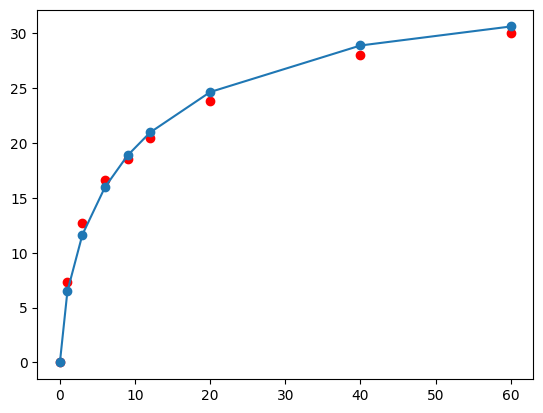

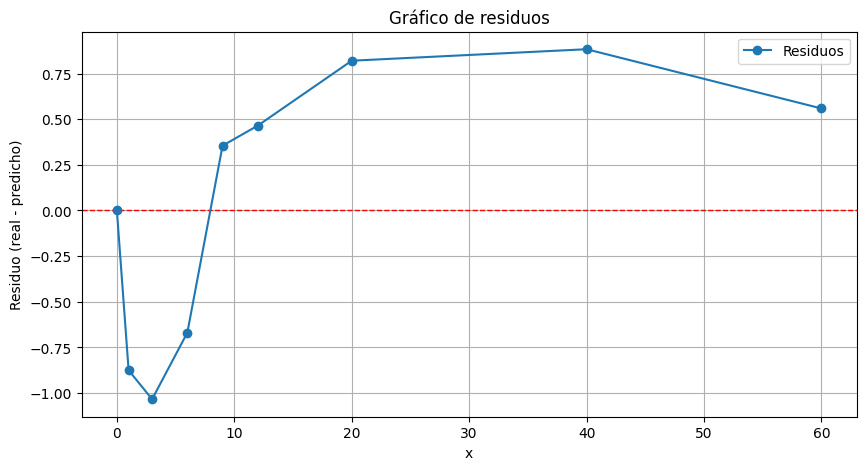

In [10]:

processes = {
    "adsorption": {"e_ads": 0.098, "e_int_abs": 0.055},
    "desorption": {"e_des": 0.17}
}
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 700

# Elegí la red: Square o Hexagonal
lattice = HexagonalLattice(size=lattice_size)  # o HexagonalLattice(size=10)

# Crear y correr el modelo
kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
occupancy = kmc.run_simulation()

# Ver resultados básicos
print("Ocupación final:", occupancy[time_array[-1]])
print("Energía final:", kmc.calculate_total_energy())


simulated_data = occupancy.values()
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.scatter(time_array, data.iloc[0, :9].to_numpy(),color = 'red', label='Experimental data')
mse = np.mean((data.iloc[0, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")
print(kmc.events_count)

# Cálculo de residuos
residuos = np.array(list(simulated_data)) - data.iloc[0, :9].to_numpy()

# Gráfico de residuos
plt.figure(figsize=(10, 5))
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.plot(time_array, residuos, marker='o', linestyle='-', label='Residuos')
plt.title('Gráfico de residuos')
plt.xlabel('x')
plt.ylabel('Residuo (real - predicho)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
percentage = 0.6

param_ranges = {
    param: (value * (1 - percentage), value * (1 + percentage))
    for process in processes.values()
    for param, value in process.items()
}
param_ranges['lattice_size'] = (600, 800)
param_ranges['T'] = (300, 301)

optimizer = KMCModelOptimizer(
    exp_data=data.iloc[0, :9].to_numpy(),
    param_ranges=param_ranges,
    lattice_class=HexagonalLattice,  # o SquareLattice
    n_calls=100
)

optimizer.optimize()

🚀 Optimización Bayesiana:  97%|▉| 97/100 [52:28<11:49, 236.57s/eval, Mejor error=0.529163, Progreso

Ocupación final: 30.386666666666667
Energía final: 18546.545425268327


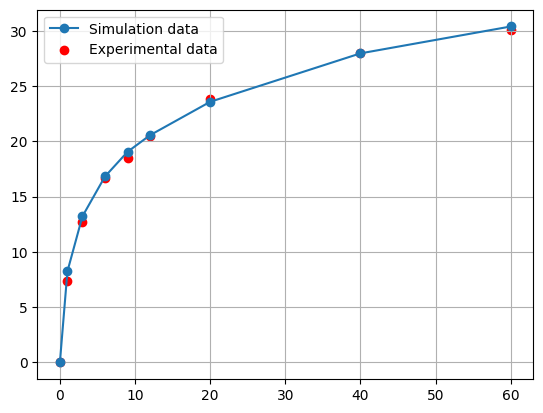

Mean Squared Error (MSE): 0.17325130844870962
{'adsorption': 130621, 'desorption': 161}


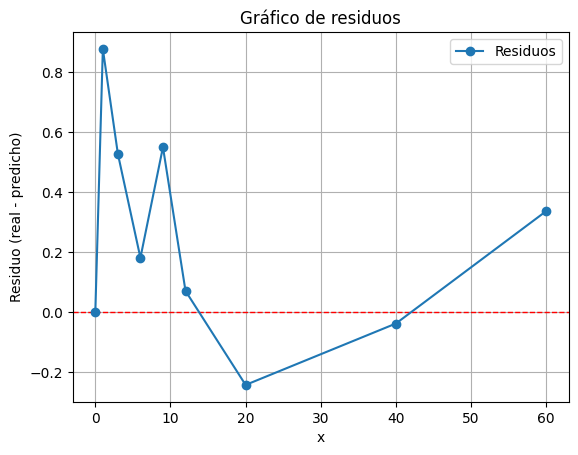

In [25]:
processes = {
    "adsorption": {"e_ads": 0.09023405539892604, "e_int_abs": 0.043612945833991446},
    "desorption": {"e_des": 0.23688561031325336, "e_int_des": 0.7}
}
T = 300.57772973331004
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 600

# Elegí la red: Square o Hexagonal
lattice = HexagonalLattice(size=lattice_size)  # o HexagonalLattice(size=10)

# Crear y correr el modelo
kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
occupancy = kmc.run_simulation()

# Ver resultados básicos
print("Ocupación final:", occupancy[time_array[-1]])
print("Energía final:", kmc.calculate_total_energy())


test = [
    np.float64(0.0),
    np.float64(8.28694444),
    np.float64(13.03083333),
    np.float64(16.45027778),
    np.float64(18.29638889),
    np.float64(20.15527778),
    np.float64(23.04583333),
    np.float64(27.6475),
    np.float64(30.81916667)
]

simulated_data = occupancy.values()
plt.plot(time_array,simulated_data, marker='o', label='Simulation data')
plt.scatter(time_array, data.iloc[0, :9].to_numpy(),color = 'red', label='Experimental data')
plt.legend()
plt.grid(True)
plt.show()

mse = np.mean((data.iloc[0, :9].to_numpy() - np.array(list(simulated_data))) ** 2)
print(f"Mean Squared Error (MSE): {mse}")
print(kmc.events_count)

# Cálculo de residuos
residuos = np.array(list(simulated_data)) - data.iloc[0, :9].to_numpy()

# Gráfico de residuos

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.plot(time_array, residuos, marker='o', linestyle='-', label='Residuos')
plt.title('Gráfico de residuos')
plt.xlabel('x')
plt.ylabel('Residuo (real - predicho)')
plt.legend()
plt.grid(True)
plt.show()

Parámetros ajustados:
  q_e = 31.2199 mg/g
  k_n = 0.0381 1/min
  n = 2.3974


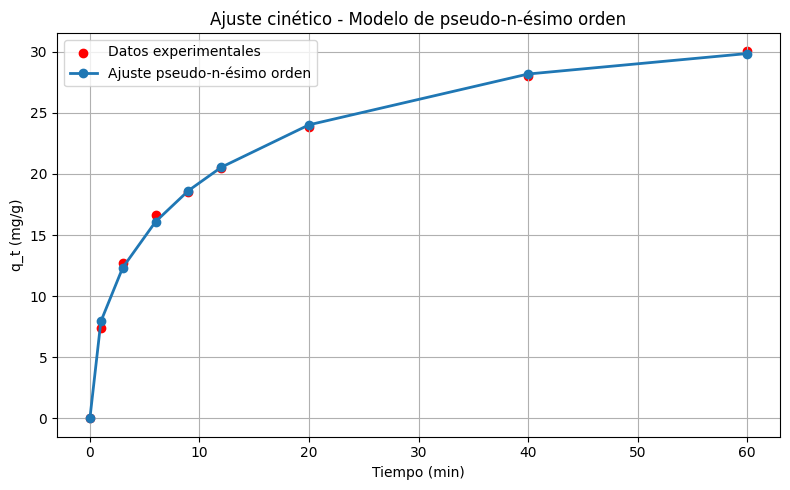

In [22]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Datos experimentales
t_exp = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])  # Tiempo en minutos
qt_exp = data.iloc[0, :9].to_numpy()# qt en mg/g

# Definición del modelo de pseudo-n-ésimo orden
def pseudo_n_order(t, q_e, k_n, n):
    return q_e * (1 - np.exp(-k_n * t)) ** (1 / n)

# Ajuste de los datos
p0 = [30, 0.1, 2]  # Valores iniciales para q_e, k_n y n
params_opt, _ = curve_fit(pseudo_n_order, t_exp, qt_exp, p0=p0)
q_e_fit, k_n_fit, n_fit = params_opt

# Generación de datos ajustados
t_fit = t_exp
qt_fit = pseudo_n_order(t_fit, q_e_fit, k_n_fit, n_fit)

# Mostrar resultados
print(f"Parámetros ajustados:\n  q_e = {q_e_fit:.4f} mg/g\n  k_n = {k_n_fit:.4f} 1/min\n  n = {n_fit:.4f}")

# Gráfica
plt.figure(figsize=(8, 5))
plt.scatter(t_exp, qt_exp, color='red', label='Datos experimentales')
plt.plot(t_fit, qt_fit, marker = 'o', label='Ajuste pseudo-n-ésimo orden', linewidth=2)
plt.xlabel('Tiempo (min)')
plt.ylabel('q_t (mg/g)')
plt.title('Ajuste cinético - Modelo de pseudo-n-ésimo orden')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


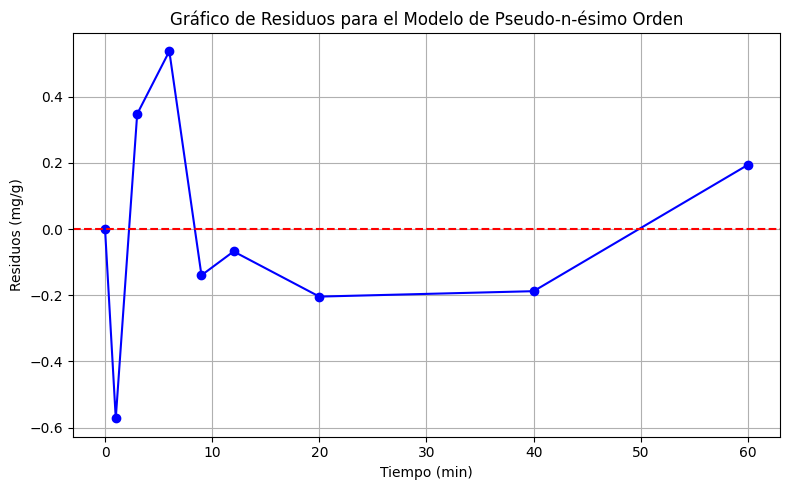

Error Cuadrático Medio (MSE) del ajuste de pseudo-n-ésimo orden: 0.0972


In [19]:
# prompt: haz un gráfico de residuos con el último ajuste hecho y calcula el errror cuadratico medio

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Calculate residuals for the last fit (pseudo-n-order)
residuals = qt_exp - pseudo_n_order(t_exp, q_e_fit, k_n_fit, n_fit)

# Plot the residuals
plt.figure(figsize=(8, 5))
plt.plot(t_exp, residuals, marker = 'o', color='blue')
plt.axhline(y=0, color='red', linestyle='--') # Add a line at y=0 for reference
plt.xlabel('Tiempo (min)')
plt.ylabel('Residuos (mg/g)')
plt.title('Gráfico de Residuos para el Modelo de Pseudo-n-ésimo Orden')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(qt_exp, pseudo_n_order(t_exp, q_e_fit, k_n_fit, n_fit))

print(f"Error Cuadrático Medio (MSE) del ajuste de pseudo-n-ésimo orden: {mse:.4f}")

In [27]:
percentage = 0.6

param_ranges = {
    param: (value * (1 - percentage), value * (1 + percentage))
    for process in processes.values()
    for param, value in process.items()
}
param_ranges['lattice_size'] = (600, 800)
param_ranges['T'] = (300, 301)

optimizer = KMCModelOptimizer(
    exp_data=data.iloc[0, :9].to_numpy(),
    param_ranges=param_ranges,
    lattice_class=SquareLattice,  # o SquareLattice
    n_calls=100
)

optimizer.optimize()

🚀 Optimización Bayesiana:  84%|▊| 84/100 [1:12:36<16:56, 63.52s/eval, Mejor error=0.819423, Progres

KeyboardInterrupt: 